In [1]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
from pathlib import Path
from datetime import date, timedelta
import re
import multiprocessing as mult
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
tester = pd.read_csv('../scraping_raw/203.csv')

## Extracting games

First we will process a random batch, we will use the regular expression package to extract the games from the tweets.

In [3]:
tester['processed_text'] = tester['Text'].apply(lambda x: re.findall("[‚¨õüü®üü©‚¨ú]{5}", x))

In [4]:
tester.head()

Unnamed: 0  Game Trial                   Datetime             Tweet Id  \
0           0   203     1  2022-01-08 23:53:02+00:00  1479964391839834119   
1           1   203     1  2022-01-08 23:49:28+00:00  1479963495806427136   
2           2   203     1  2022-01-08 23:29:51+00:00  1479958559467126784   
3           3   203     1  2022-01-08 23:24:13+00:00  1479957142337585154   
4           4   203     1  2022-01-08 23:17:06+00:00  1479955350111596545   

                                                Text        Username  \
0                            Wordle 203 1/6\n\nüü©üü©üü©üü©üü©      danielebel   
1  Wordle 203 1/6\n\nüü©üü©üü©üü©üü©\n\nRandomly guessing a...   glamdring1999   
2  First time Wordling.\nTime to quit.\n\nWordle ...       Axialmatt   
3  Wordle 203 1/6\n\nüü©üü©üü©üü©üü©  \n\nü§∑‚Äç‚ôÇÔ∏èü§∑‚Äç‚ôÇÔ∏èü§∑‚Äç‚ôÇÔ∏èü§∑‚Äç‚ôÇÔ∏èü§∑‚Äç‚ôÇÔ∏è         _yaowu_   
4                            Wordle 203 1/6\n\nüü©üü©üü©üü©üü©  sagitariusslut   

                                                 URL processed_text  
0  https://twitter.com/danielebel/status/14799643...        [üü©üü©üü©üü©üü©]  
1  https://twitter.com/glamdring1999/status/14799...        [üü©üü©üü©üü©üü©]  
2  https://twitter.com/Axialmatt/status/147995855...        [üü©üü©üü©üü©üü©]  
3  https://twitter.com/_yaowu_/status/14799571423...        [üü©üü©üü©üü©üü©]  
4  https://twitter.com/sagitariusslut/status/1479...        [üü©üü©üü©üü©üü©]

Now we will create a column called which will contain the number of trials for each extracted game.
We will also change the trial column in order to change the 'X' position to the number 6.

In [5]:
tester['proc_length'] = tester['processed_text'].str.len()

In [6]:
tester['Trial'] = tester['Trial'].apply(lambda x: 6 if x == 'X' else int(x))

##  Premilinar data cleaning

Now we will discard any entries where the number of attemps in the header does not correspond to the number of extracted trials.

In [7]:
tester = tester.loc[tester['proc_length'] == tester['Trial']]
tester.head()

Unnamed: 0  Game  Trial                   Datetime             Tweet Id  \
0           0   203      1  2022-01-08 23:53:02+00:00  1479964391839834119   
1           1   203      1  2022-01-08 23:49:28+00:00  1479963495806427136   
2           2   203      1  2022-01-08 23:29:51+00:00  1479958559467126784   
3           3   203      1  2022-01-08 23:24:13+00:00  1479957142337585154   
4           4   203      1  2022-01-08 23:17:06+00:00  1479955350111596545   

                                                Text        Username  \
0                            Wordle 203 1/6\n\nüü©üü©üü©üü©üü©      danielebel   
1  Wordle 203 1/6\n\nüü©üü©üü©üü©üü©\n\nRandomly guessing a...   glamdring1999   
2  First time Wordling.\nTime to quit.\n\nWordle ...       Axialmatt   
3  Wordle 203 1/6\n\nüü©üü©üü©üü©üü©  \n\nü§∑‚Äç‚ôÇÔ∏èü§∑‚Äç‚ôÇÔ∏èü§∑‚Äç‚ôÇÔ∏èü§∑‚Äç‚ôÇÔ∏èü§∑‚Äç‚ôÇÔ∏è         _yaowu_   
4                            Wordle 203 1/6\n\nüü©üü©üü©üü©üü©  sagitariusslut   

                                                 URL processed_text  \
0  https://twitter.com/danielebel/status/14799643...        [üü©üü©üü©üü©üü©]   
1  https://twitter.com/glamdring1999/status/14799...        [üü©üü©üü©üü©üü©]   
2  https://twitter.com/Axialmatt/status/147995855...        [üü©üü©üü©üü©üü©]   
3  https://twitter.com/_yaowu_/status/14799571423...        [üü©üü©üü©üü©üü©]   
4  https://twitter.com/sagitariusslut/status/1479...        [üü©üü©üü©üü©üü©]   

   proc_length  
0            1  
1            1  
2            1  
3            1  
4            1

Now we will check if any games of less than six trials don't end in a victory.

In [8]:
len(tester)

25020

In [9]:
len(tester.loc[(tester['processed_text'].str[-1] == "üü©üü©üü©üü©üü©") & tester['Trial'] < 6])

25020

Even though in this case we were lucky, we will still write the lines of code to discard the wrong entries just to have it in general case.

In [10]:
valid_games = tester.loc[(tester['processed_text'].str[-1] == "üü©üü©üü©üü©üü©") & tester['Trial'] < 6]
six_trials = tester.loc[tester['Trial'] == 6 & (tester['processed_text'].str[-1] != "üü©üü©üü©üü©üü©")]
tester = pd.concat([valid_games, six_trials])

## Processing all batches

Now we will start processing each dataset that we have extracted in the previous notebook using the commands used in the first part of this file. Before that we will run some trials to find out some information about the posible errors present in our dataset.

### Finding the total number of entries

In [27]:
data = pd.DataFrame()
for i in range(196, 516):
    game = pd.read_csv('../scraping_raw/' + str(i) + '.csv')
    data = pd.concat([data, game])
    print('Batch ' + str(i) + ' completed')
print(len(data))

Batch 196 completed
Batch 197 completed
Batch 198 completed
Batch 199 completed
Batch 200 completed
Batch 201 completed
Batch 202 completed
Batch 203 completed
Batch 204 completed
Batch 205 completed
Batch 206 completed
Batch 207 completed
Batch 208 completed
Batch 209 completed
Batch 210 completed
Batch 211 completed
Batch 212 completed
Batch 213 completed
Batch 214 completed
Batch 215 completed
Batch 216 completed
Batch 217 completed
Batch 218 completed
Batch 219 completed
Batch 220 completed
Batch 221 completed
Batch 222 completed
Batch 223 completed
Batch 224 completed
Batch 225 completed
Batch 226 completed
Batch 227 completed
Batch 228 completed
Batch 229 completed
Batch 230 completed
Batch 231 completed
Batch 232 completed
Batch 233 completed
Batch 234 completed
Batch 235 completed
Batch 236 completed
Batch 237 completed
Batch 238 completed
Batch 239 completed
Batch 240 completed
Batch 241 completed
Batch 242 completed
Batch 243 completed
Batch 244 completed
Batch 245 completed


### Finding the number of entries with discrepancies between trials

In [28]:
data['processed_text'] = data['Text'].apply(lambda x: re.findall("[‚¨õüü®üü©‚¨ú]{5}", x))

In [29]:
data['game_length'] = data['Trial'].apply(lambda x: 6 if x == 'X' else int(x))
discr_trials = data.loc[data['game_length'] != data['processed_text'].str.len()]
print('The number of games with discrepancies in trials is: ' + str(len(discr_trials)))

The number of games with discrepancies in trials is: 147085


In [30]:
data = data.loc[data['game_length'] == data['processed_text'].str.len()]

### Number of remaining winning games with discrepancies

In [31]:
win_discr = data.loc[(data['Trial'] != 'X') & (data['processed_text'].str[-1] != "üü©üü©üü©üü©üü©")]
print('The number of remaining winning games with discrepancies is ' + str(len(win_discr)))

The number of remaining winning games with discrepancies is 278


### Number of remaining losing games with discrepancies

In [29]:
lose_discr = data.loc[(data['Trial'] == 'X') & (data['processed_text'].str[-1] == "üü©üü©üü©üü©üü©")]
print('The number of remaining losing games with discrepancies is ' + str(len(lose_discr)))

The number of remaining losing games with discrepancies is 998


### Number of games with wins inbetween tries

In [3]:
def impossible_game(game):
    for i in range(0, len(game)-2):
        if game[i] == "üü©üü©üü©üü©üü©":
            return False
    return True

In [34]:
data_err = data.loc[data['processed_text'].apply(impossible_game) == False]
print('The number of remaining games with wins in the middle is ' + str(len(data_err)))

The number of remaining games with wins in the middle is 116


### Processing all the batches

In [4]:
pd.options.mode.chained_assignment = None  # default='warn'
data = pd.DataFrame()
for i in range(196, 516):
    print("Processing batch: " + str(i))
    game = pd.read_csv('../scraping_raw/' + str(i) + '.csv')
    game['processed_text'] = game['Text'].apply(lambda x: re.findall("[‚¨õüü®üü©‚¨ú]{5}", x))
    game['proc_length'] = game['processed_text'].str.len()
    game['game_length'] = game['Trial'].apply(lambda x: 6 if x == 'X' else int(x))
    game = game.loc[game['proc_length'] == game['game_length']]
    game = game.loc[game['processed_text'].apply(impossible_game) == True]
    valid_games = game.loc[(game['processed_text'].str[-1] == "üü©üü©üü©üü©üü©") & (game['Trial'] != 'X')]
    valid_games['Trial'] = valid_games['proc_length']
    failed_games = game.loc[(game['Trial'] == 'X') & (game['processed_text'].str[-1] != "üü©üü©üü©üü©üü©")]
    failed_games['Trial'] = 7
    game = pd.concat([valid_games, failed_games])
    game = game.drop(['game_length'], axis = 1)
    data = pd.concat([data, game])
    print("Completed "+str(i))

Processing batch: 196
Completed 196
Processing batch: 197
Completed 197
Processing batch: 198
Completed 198
Processing batch: 199
Completed 199
Processing batch: 200
Completed 200
Processing batch: 201
Completed 201
Processing batch: 202
Completed 202
Processing batch: 203
Completed 203
Processing batch: 204
Completed 204
Processing batch: 205
Completed 205
Processing batch: 206
Completed 206
Processing batch: 207
Completed 207
Processing batch: 208
Completed 208
Processing batch: 209
Completed 209
Processing batch: 210
Completed 210
Processing batch: 211
Completed 211
Processing batch: 212
Completed 212
Processing batch: 213
Completed 213
Processing batch: 214
Completed 214
Processing batch: 215
Completed 215
Processing batch: 216
Completed 216
Processing batch: 217
Completed 217
Processing batch: 218
Completed 218
Processing batch: 219
Completed 219
Processing batch: 220
Completed 220
Processing batch: 221
Completed 221
Processing batch: 222
Completed 222
Processing batch: 223
Comple

Completed 423
Processing batch: 424
Completed 424
Processing batch: 425
Completed 425
Processing batch: 426
Completed 426
Processing batch: 427
Completed 427
Processing batch: 428
Completed 428
Processing batch: 429
Completed 429
Processing batch: 430
Completed 430
Processing batch: 431
Completed 431
Processing batch: 432
Completed 432
Processing batch: 433
Completed 433
Processing batch: 434
Completed 434
Processing batch: 435
Completed 435
Processing batch: 436
Completed 436
Processing batch: 437
Completed 437
Processing batch: 438
Completed 438
Processing batch: 439
Completed 439
Processing batch: 440
Completed 440
Processing batch: 441
Completed 441
Processing batch: 442
Completed 442
Processing batch: 443
Completed 443
Processing batch: 444
Completed 444
Processing batch: 445
Completed 445
Processing batch: 446
Completed 446
Processing batch: 447
Completed 447
Processing batch: 448
Completed 448
Processing batch: 449
Completed 449
Processing batch: 450
Completed 450
Processing bat

In [6]:
data.head()

Unnamed: 0  Game  Trial                   Datetime             Tweet Id  \
0           0   196      1  2022-01-01 23:49:38+00:00  1477426821763268611   
1           1   196      1  2022-01-01 23:33:35+00:00  1477422784217112578   
2           2   196      1  2022-01-01 20:25:45+00:00  1477375513580621825   
3           3   196      1  2022-01-01 20:18:26+00:00  1477373674034327554   
4           4   196      1  2022-01-01 19:15:18+00:00  1477357786061099011   

                                                Text         Username  \
0  This is becoming tiresome: Wordle 196 1/6\n\nüü©...     adamhorsfall   
1                            Wordle 196 1/6\n\nüü©üü©üü©üü©üü©     TheRealPembo   
2  Saw a not-cryptic-enough spoiler, unfortunatel...           grenow   
3  This is a goid start to 2022\n\nWordle 196 1/6...         Yummhh__   
4                            Wordle 196 1/6\n\nüü©üü©üü©üü©üü©  TowerGuardGames   

                                                 URL processed_text  \
0  https://twitter.com/adamhorsfall/status/147742...        [üü©üü©üü©üü©üü©]   
1  https://twitter.com/TheRealPembo/status/147742...        [üü©üü©üü©üü©üü©]   
2  https://twitter.com/grenow/status/147737551358...        [üü©üü©üü©üü©üü©]   
3  https://twitter.com/Yummhh__/status/1477373674...        [üü©üü©üü©üü©üü©]   
4  https://twitter.com/TowerGuardGames/status/147...        [üü©üü©üü©üü©üü©]   

   proc_length  
0            1  
1            1  
2            1  
3            1  
4            1

In [8]:
print('The number of games after the preliminary cleaning is ' + str(len(data)))

The number of games after the preliminary cleaning is 6954106


Now we will drop some unnceseary columns.

In [9]:
data = data.drop(['proc_length', 'Tweet Id', 'URL', 'Unnamed: 0', 'Text', 'Datetime'], axis = 1)

Now we will change all of the ‚¨õ characters into ‚¨ú:

In [10]:
data['processed_text'] = data['processed_text'].apply(lambda x : [word.replace('‚¨õ', '‚¨ú') for word in x])

Now we will save the processed data:

In [12]:
data = data.reset_index()
data.to_feather('data_proc_ver_1.feather')

## Secondary cleaning

Now we will create a function that will return all the possible combinations of colors that can be generated given a target word. In order to do we will split it into smaller functions.

In [56]:
data = pd.read_feather('data_proc_ver_1.feather')

In [57]:
def find(s, ch):
    return [i for i, ltr in enumerate(s) if ltr == ch]

In [58]:
def check_words(input_word ,target):
    input_word = input_word.lower()
    target = target.lower()
    sequence = ['‚¨ú']*5
    selected = [False]*5
    for i in range(0,5):
        if input_word[i] == target[i]:
            sequence[i] = 'üü©'
            selected[i] = True
    for i in range(0,5):
        if input_word[i] != target[i]:
            indexes = find(target, input_word[i])
            for index in indexes:
                if not selected[index]:
                    selected[index] = True
                    sequence[i] = 'üü®'
                    break
    aux = ""
    return aux.join(sequence)

Now we will check the function in order to see if it works as inteded.

In [59]:
words = ['algae', 'keeps', 'orbit', 'abate', 'abbey']
for word in words:
    print(check_words(word, 'abbey'))

üü©‚¨ú‚¨ú‚¨úüü®
‚¨úüü®‚¨ú‚¨ú‚¨ú
‚¨ú‚¨úüü©‚¨ú‚¨ú
üü©üü©‚¨ú‚¨úüü®
üü©üü©üü©üü©üü©


Now we will create the function that returns the set of all posible combinations given a word.

In [60]:
def set_of_words(possible_inputs, target):
    result = set()
    for word in possible_inputs:
        result.add(check_words(word, target))
    return result

In [61]:
set_of_words(words, 'abbey')

{'‚¨ú‚¨úüü©‚¨ú‚¨ú', '‚¨úüü®‚¨ú‚¨ú‚¨ú', 'üü©‚¨ú‚¨ú‚¨úüü®', 'üü©üü©‚¨ú‚¨úüü®', 'üü©üü©üü©üü©üü©'}

### Creating the allowed words set

Now that we have created the functions needed to pass the second cleaning, we will now compute the set of all the valid words that can be used as inputs in Wordle (from an .txt file in the repository) and also a dictionary that will link the game number with the game's target word.

In [62]:
#set of valid words
valid_inputs = []
with open("valid-wordle-words.txt") as f:
    valid_inputs = f.read().splitlines()

In [63]:
#dictionary of games and target words
game_dict = {}
with open("wordle-words-by-day.txt") as f:
    for line in f:
        line = line.strip()
        game_dict.update({int(line[0:3]) : line[4::]})

#### Adding the target word of the day
Now we will add an extra column which will be the target word associated with the game number.

In [64]:
data['target'] = data['Game'].apply(lambda x: game_dict[x])

In [65]:
data

index  Game  Trial         Username  \
0            0   196      1     adamhorsfall   
1            1   196      1     TheRealPembo   
2            2   196      1           grenow   
3            3   196      1         Yummhh__   
4            4   196      1  TowerGuardGames   
...        ...   ...    ...              ...   
6954101  19156   515      7     moona_moony_   
6954102  19157   515      7       JonMDexter   
6954103  19158   515      7       KuronaNuva   
6954104  19159   515      7           KZYONE   
6954105  19160   515      7       Robtrinity   

                                     processed_text target  
0                                           [üü©üü©üü©üü©üü©]  REBUS  
1                                           [üü©üü©üü©üü©üü©]  REBUS  
2                                           [üü©üü©üü©üü©üü©]  REBUS  
3                                           [üü©üü©üü©üü©üü©]  REBUS  
4                                           [üü©üü©üü©üü©üü©]  REBUS  
...                                             ...    ...  
6954101  [üü®‚¨ú‚¨ú‚¨úüü®, ‚¨úüü®üü®‚¨ú‚¨ú, ‚¨ú‚¨úüü®üü®üü©, ‚¨úüü©‚¨úüü©üü©, ‚¨úüü©‚¨úüü©üü©, ‚¨úüü©‚¨úüü©üü©]  BAKER  
6954102  [‚¨ú‚¨ú‚¨ú‚¨úüü©, ‚¨ú‚¨ú‚¨úüü©üü©, ‚¨úüü©‚¨úüü©üü©, ‚¨úüü©‚¨úüü©üü©, ‚¨úüü©üü©üü©üü©, ‚¨úüü©üü©üü©üü©]  BAKER  
6954103  [‚¨úüü®üü®‚¨úüü®, üü®üü©üü®‚¨ú‚¨ú, ‚¨úüü©‚¨úüü©üü©, ‚¨úüü©‚¨úüü©üü©, ‚¨úüü©‚¨úüü©üü©, ‚¨úüü©‚¨úüü©üü©]  BAKER  
6954104  [üü®üü®üü®‚¨ú‚¨ú, ‚¨úüü®üü®üü®‚¨ú, ‚¨ú‚¨úüü®üü®üü®, ‚¨úüü©‚¨úüü©üü©, ‚¨úüü©‚¨úüü©üü©, ‚¨úüü©‚¨úüü©üü©]  BAKER  
6954105  [‚¨ú‚¨úüü®‚¨ú‚¨ú, ‚¨úüü®üü®‚¨úüü®, üü®üü©‚¨úüü©‚¨ú, ‚¨úüü©‚¨úüü©üü©, ‚¨úüü©‚¨úüü©üü©, ‚¨úüü©‚¨úüü©üü©]  BAKER  

[6954106 rows x 6 columns]

### Generating the a set of all posible outcomes for each target

Now we will create a dictionary which will have the game number as keys and each entry will contain the set of all posible outcomes that can be generated.


In [66]:
posible_games = {}
for i in range(196, 516):
    posible_games.update({i:set_of_words(valid_inputs, game_dict[i])})

### Finding the games with imposible combinations

Now we will find the games that contain an entry that could not have been generated by the target word

In [67]:
def checker(texts, game):
    return all([word in posible_games[game] for word in texts])

In [68]:
data['valid_game'] = data[['processed_text', 'Game']].apply(lambda x: checker(x.processed_text, x.Game), axis=1)

In [69]:
wrong = data.loc[data['valid_game'] == False]
wrong

index  Game  Trial         Username  \
5031      5133   196      5          2BLuis1   
13402     4371   197      3  SittingByTheSea   
20408    11506   197      5     Battysgambit   
25163     2735   198      3  _Anna_Weigandt_   
39659      581   199      2      romapancake   
...        ...   ...    ...              ...   
6953438  18473   515      7        fer4lfrog   
6953607  18648   515      7         Monshi41   
6953698  18741   515      7     Watching_One   
6953824  18873   515      7  Louise_Bullock_   
6953969  19021   515      7        daikouzui   

                                     processed_text target  valid_game  
5031            [‚¨ú‚¨úüü®üü®‚¨ú, üü©üü©‚¨ú‚¨ú‚¨ú, üü©üü©‚¨ú‚¨ú‚¨ú, üü©üü©üü©üü®üü®, üü©üü©üü©üü©üü©]  REBUS       False  
13402                         [üü®üü®‚¨ú‚¨úüü®, üü®‚¨úüü©üü®üü®, üü©üü©üü©üü©üü©]  BOOST       False  
20408           [‚¨ú‚¨úüü®üü®‚¨ú, üü®‚¨úüü®‚¨úüü®, üü©‚¨ú‚¨úüü®üü©, üü©üü®‚¨úüü®üü©, üü©üü©üü©üü©üü©]  BOOST       False  
25163                         [üü®üü®üü®üü®‚¨ú, üü©üü®üü©‚¨úüü©, üü©üü©üü©üü©üü©]  TRUSS       False  
39659                                [üü®‚¨ú‚¨úüü©üü®, üü©üü©üü©üü©üü©]  SIEGE       False  
...                                             ...    ...         ...  
6953438  [üü®‚¨ú‚¨úüü®‚¨ú, üü®‚¨ú‚¨ú‚¨úüü®, üü®üü®üü®‚¨úüü©, ‚¨úüü®üü®üü©üü©, üü©üü©‚¨úüü©üü©, üü©üü©‚¨úüü©üü©]  BAKER       False  
6953607  [‚¨ú‚¨úüü®üü®‚¨ú, üü®üü®‚¨ú‚¨ú‚¨ú, ‚¨ú‚¨ú‚¨úüü®üü®, ‚¨úüü®‚¨ú‚¨úüü©, ‚¨úüü©üü©‚¨úüü©, üü©üü©üü©‚¨úüü©]  BAKER       False  
6953698  [‚¨ú‚¨ú‚¨úüü®‚¨ú, ‚¨ú‚¨úüü©üü®‚¨ú, ‚¨úüü©üü©‚¨úüü©, ‚¨úüü©üü©‚¨úüü©, üü©‚¨úüü©‚¨úüü©, üü©üü©üü©‚¨úüü©]  BAKER       False  
6953824  [‚¨ú‚¨ú‚¨ú‚¨úüü®, ‚¨úüü®üü®üü®‚¨ú, üü®üü®üü®‚¨ú‚¨ú, üü®üü®üü®‚¨ú‚¨ú, ‚¨úüü®üü®üü®üü®, üü®üü©üü®üü©‚¨ú]  BAKER       False  
6953969  [üü®‚¨ú‚¨ú‚¨ú‚¨ú, ‚¨ú‚¨ú‚¨ú‚¨úüü®, ‚¨ú‚¨ú‚¨ú‚¨ú‚¨ú, ‚¨úüü®‚¨ú‚¨ú‚¨ú, üü®‚¨ú‚¨úüü©‚¨ú, üü®üü©üü®üü©‚¨ú]  BAKER       False  

[35415 rows x 7 columns]

Now we will take a look to the distribution just in case we might have an invalid input in the dictionary.

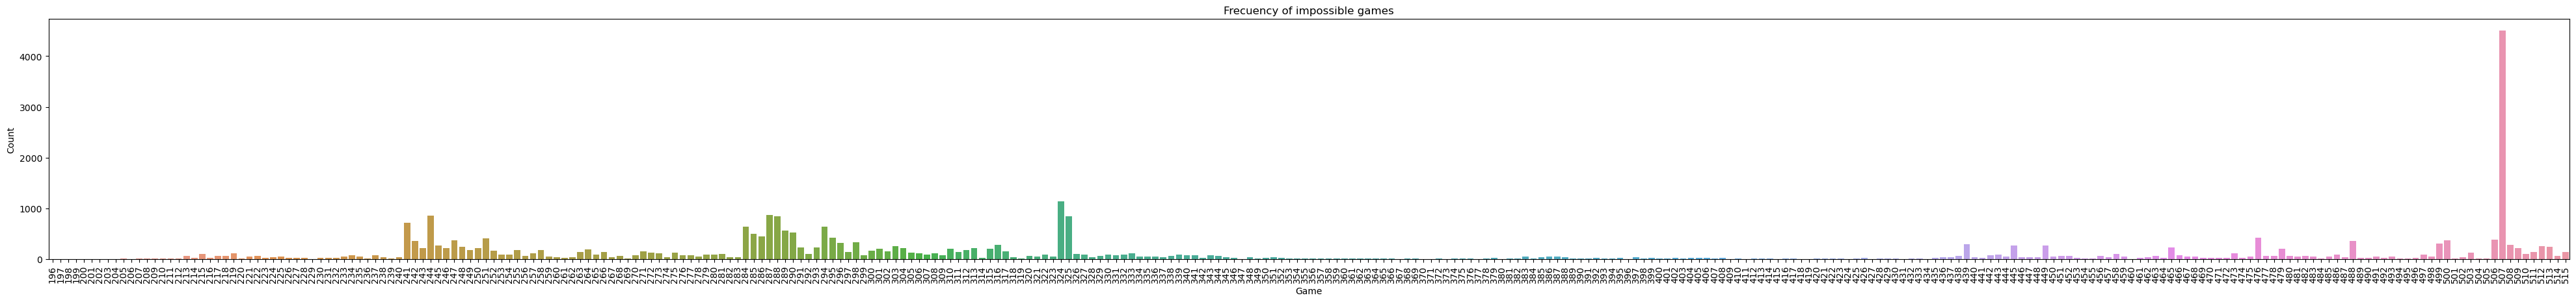

In [70]:
word_plot = sns.countplot(data = wrong, x = 'Game')
word_plot.set_xlabel("Game")
word_plot.set_ylabel("Count")
word_plot.set_title("Frecuency of impossible games")
word_plot.set_xticklabels(labels = word_plot.get_xticklabels() ,rotation = 90)
word_plot.figure.set_figwidth(50);

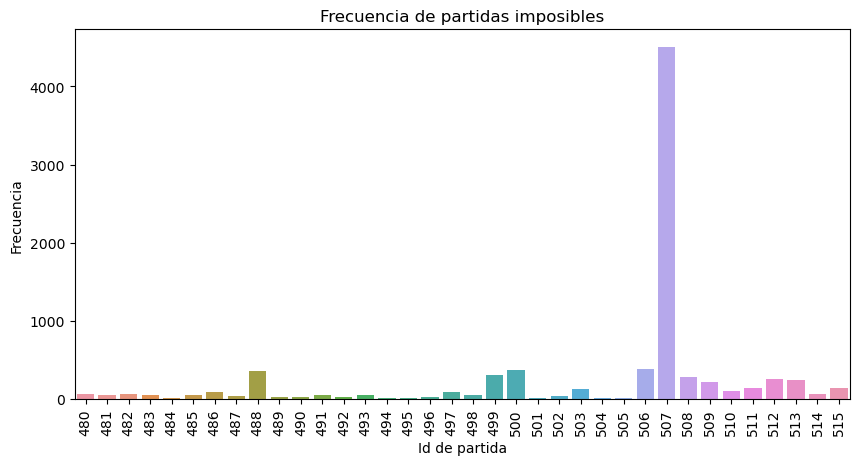

In [71]:
small_w = wrong.loc[wrong['Game'] > 479]
word_plot = sns.countplot(data = small_w, x = 'Game')
word_plot.set_xlabel("Id de partida")
word_plot.set_ylabel("Frecuencia")
word_plot.set_title("Frecuencia de partidas imposibles")
word_plot.set_xticklabels(labels = word_plot.get_xticklabels() ,rotation = 90);
word_plot.figure.set_figwidth(10);

In [38]:
fig = word_plot.get_figure()
fig.savefig('imposible_games1.png')

There's something unusual in a word, let's take a look:

In [56]:
wrong_count = wrong.groupby(by = ['Game'])['Game'].count()
wrong_count

Game
196      1
197      2
198      1
199      5
200      5
      ... 
511    147
512    252
513    244
514     69
515    146
Name: Game, Length: 320, dtype: int64

In [57]:
wrong_count.idxmax()

507

We can see that the peak appears at game 507, let's see what's happening.

In [58]:
outlier = wrong.loc[wrong['Game'] == 507]
outlier

index  Game  Trial      Username  \
6799724     54   507      2   jeanne_blue   
6799726     56   507      2     samonoise   
6799735     65   507      2     M_A_M_0_5   
6799741     72   507      2        baikap   
6799759     91   507      2  GusYorkshire   
...        ...   ...    ...           ...   
6816925  17643   507      7     detatan1q   
6816927  17645   507      7      TheLUPOL   
6816928  17646   507      7        DiB164   
6816929  17647   507      7    echi_go_ya   
6816935  17653   507      7      Al_in_TX   

                                     processed_text target  valid_game  
6799724                              [üü©üü©üü®‚¨ú‚¨ú, üü©üü©üü©üü©üü©]  SNARL       False  
6799726                              [üü©‚¨úüü©üü©üü©, üü©üü©üü©üü©üü©]  SNARL       False  
6799735                              [üü©üü©‚¨úüü®üü©, üü©üü©üü©üü©üü©]  SNARL       False  
6799741                              [üü®‚¨úüü®üü©üü®, üü©üü©üü©üü©üü©]  SNARL       False  
6799759                              [üü©‚¨úüü©üü©üü©, üü©üü©üü©üü©üü©]  SNARL       False  
...                                             ...    ...         ...  
6816925  [üü®‚¨ú‚¨ú‚¨ú‚¨ú, ‚¨úüü®‚¨ú‚¨ú‚¨ú, ‚¨ú‚¨úüü®üü®‚¨ú, üü©üü®üü®üü©‚¨ú, üü©üü®üü©‚¨úüü®, üü©üü©üü©‚¨ú‚¨ú]  SNARL       False  
6816927  [‚¨ú‚¨ú‚¨ú‚¨úüü®, üü©üü®‚¨ú‚¨úüü®, üü©‚¨úüü©‚¨úüü©, üü©‚¨úüü©üü©üü©, üü©‚¨úüü©üü©üü©, üü©‚¨úüü©üü©üü©]  SNARL       False  
6816928  [‚¨ú‚¨ú‚¨úüü®üü®, ‚¨ú‚¨ú‚¨ú‚¨ú‚¨ú, üü©üü®‚¨ú‚¨ú‚¨ú, üü©‚¨úüü©‚¨úüü©, üü©‚¨úüü©üü©üü©, üü©‚¨úüü©üü©üü©]  SNARL       False  
6816929  [‚¨ú‚¨ú‚¨ú‚¨ú‚¨ú, ‚¨ú‚¨úüü©‚¨ú‚¨ú, ‚¨úüü®üü©‚¨ú‚¨ú, ‚¨ú‚¨úüü©üü®‚¨ú, üü®üü®üü©‚¨úüü®, üü©üü®üü©‚¨úüü®]  SNARL       False  
6816935  [‚¨úüü®‚¨ú‚¨ú‚¨ú, üü®‚¨ú‚¨úüü®‚¨ú, ‚¨ú‚¨ú‚¨úüü©üü®, üü®‚¨ú‚¨úüü©‚¨ú, üü©‚¨úüü©üü©üü©, üü©‚¨úüü©üü©üü©]  SNARL       False  

[4502 rows x 7 columns]

In [59]:
outlier.describe()

index    Game        Trial
count   4502.000000  4502.0  4502.000000
mean   10900.192581   507.0     4.593736
std     4866.957130     0.0     1.095115
min       54.000000   507.0     2.000000
25%     7240.750000   507.0     4.000000
50%    11827.500000   507.0     5.000000
75%    15125.750000   507.0     5.000000
max    17653.000000   507.0     7.000000

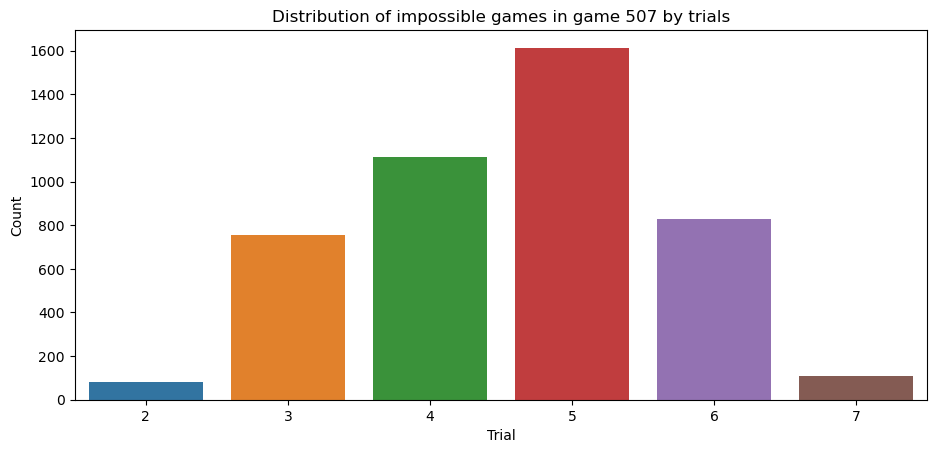

In [60]:
word_plot = sns.countplot(data = outlier, x = 'Trial')
word_plot.set_xlabel("Trial")
word_plot.set_ylabel("Count")
word_plot.set_title("Distribution of impossible games in game 507 by trials")
word_plot.figure.set_figwidth(11);

Seem a bit weird that the bulk of made up games are the ones that ended up loosing.
Since the number of invalid games is not significant, we will remove them from our dataset and perform our analysis with the remaining data.

### Changing the word snarl by the word spell

Since some other sources propose the word spell as the selected hidden word for the id game 507 we will perform our analysis again but changing this value.

In [72]:
data = pd.read_feather('data_proc_ver_1.feather')

### Creating the allowed words set

In [73]:
#set of valid words
valid_inputs = []
with open("valid-wordle-words.txt") as f:
    valid_inputs = f.read().splitlines()

In [74]:
#dictionary of games and target words
game_dict = {}
with open("wordle-words-by-day2.txt") as f:
    for line in f:
        line = line.strip()
        game_dict.update({int(line[0:3]) : line[4::]})

#### Adding the target word of the day
Now we will add an extra column which will be the target word associated with the game number.

In [75]:
data['target'] = data['Game'].apply(lambda x: game_dict[x])

### Generating the a set of all posible outcomes for each target

In [76]:
posible_games = {}
for i in range(196, 516):
    posible_games.update({i:set_of_words(valid_inputs, game_dict[i])})

### Finding the games with imposible combinations

In [77]:
def checker(texts, game):
    return all([word in posible_games[game] for word in texts])

In [78]:
data['valid_game'] = data[['processed_text', 'Game']].apply(lambda x: checker(x.processed_text, x.Game), axis=1)

In [79]:
wrong = data.loc[data['valid_game'] == False]
wrong

index  Game  Trial         Username  \
5031      5133   196      5          2BLuis1   
13402     4371   197      3  SittingByTheSea   
20408    11506   197      5     Battysgambit   
25163     2735   198      3  _Anna_Weigandt_   
39659      581   199      2      romapancake   
...        ...   ...    ...              ...   
6953438  18473   515      7        fer4lfrog   
6953607  18648   515      7         Monshi41   
6953698  18741   515      7     Watching_One   
6953824  18873   515      7  Louise_Bullock_   
6953969  19021   515      7        daikouzui   

                                     processed_text target  valid_game  
5031            [‚¨ú‚¨úüü®üü®‚¨ú, üü©üü©‚¨ú‚¨ú‚¨ú, üü©üü©‚¨ú‚¨ú‚¨ú, üü©üü©üü©üü®üü®, üü©üü©üü©üü©üü©]  REBUS       False  
13402                         [üü®üü®‚¨ú‚¨úüü®, üü®‚¨úüü©üü®üü®, üü©üü©üü©üü©üü©]  BOOST       False  
20408           [‚¨ú‚¨úüü®üü®‚¨ú, üü®‚¨úüü®‚¨úüü®, üü©‚¨ú‚¨úüü®üü©, üü©üü®‚¨úüü®üü©, üü©üü©üü©üü©üü©]  BOOST       False  
25163                         [üü®üü®üü®üü®‚¨ú, üü©üü®üü©‚¨úüü©, üü©üü©üü©üü©üü©]  TRUSS       False  
39659                                [üü®‚¨ú‚¨úüü©üü®, üü©üü©üü©üü©üü©]  SIEGE       False  
...                                             ...    ...         ...  
6953438  [üü®‚¨ú‚¨úüü®‚¨ú, üü®‚¨ú‚¨ú‚¨úüü®, üü®üü®üü®‚¨úüü©, ‚¨úüü®üü®üü©üü©, üü©üü©‚¨úüü©üü©, üü©üü©‚¨úüü©üü©]  BAKER       False  
6953607  [‚¨ú‚¨úüü®üü®‚¨ú, üü®üü®‚¨ú‚¨ú‚¨ú, ‚¨ú‚¨ú‚¨úüü®üü®, ‚¨úüü®‚¨ú‚¨úüü©, ‚¨úüü©üü©‚¨úüü©, üü©üü©üü©‚¨úüü©]  BAKER       False  
6953698  [‚¨ú‚¨ú‚¨úüü®‚¨ú, ‚¨ú‚¨úüü©üü®‚¨ú, ‚¨úüü©üü©‚¨úüü©, ‚¨úüü©üü©‚¨úüü©, üü©‚¨úüü©‚¨úüü©, üü©üü©üü©‚¨úüü©]  BAKER       False  
6953824  [‚¨ú‚¨ú‚¨ú‚¨úüü®, ‚¨úüü®üü®üü®‚¨ú, üü®üü®üü®‚¨ú‚¨ú, üü®üü®üü®‚¨ú‚¨ú, ‚¨úüü®üü®üü®üü®, üü®üü©üü®üü©‚¨ú]  BAKER       False  
6953969  [üü®‚¨ú‚¨ú‚¨ú‚¨ú, ‚¨ú‚¨ú‚¨ú‚¨úüü®, ‚¨ú‚¨ú‚¨ú‚¨ú‚¨ú, ‚¨úüü®‚¨ú‚¨ú‚¨ú, üü®‚¨ú‚¨úüü©‚¨ú, üü®üü©üü®üü©‚¨ú]  BAKER       False  

[30978 rows x 7 columns]

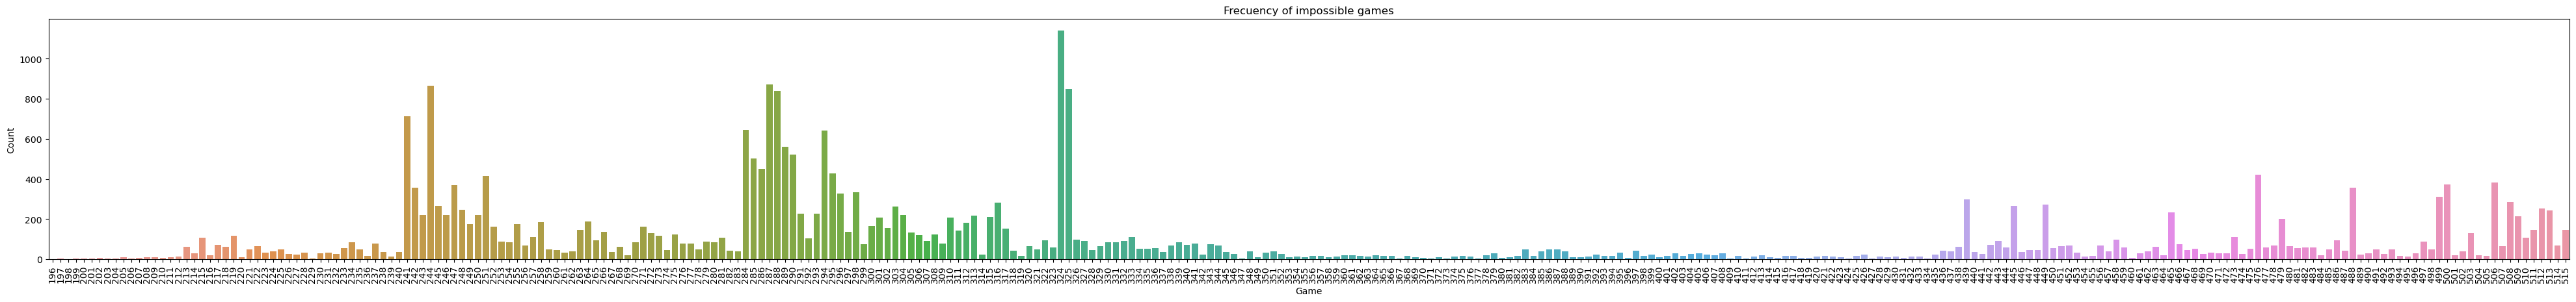

In [51]:
word_plot2 = sns.countplot(data = wrong, x = 'Game')
word_plot2.set_xlabel("Game")
word_plot2.set_ylabel("Count")
word_plot2.set_title("Frecuency of impossible games")
word_plot2.set_xticklabels(labels = word_plot.get_xticklabels() ,rotation = 90)
word_plot2.figure.set_figwidth(50);

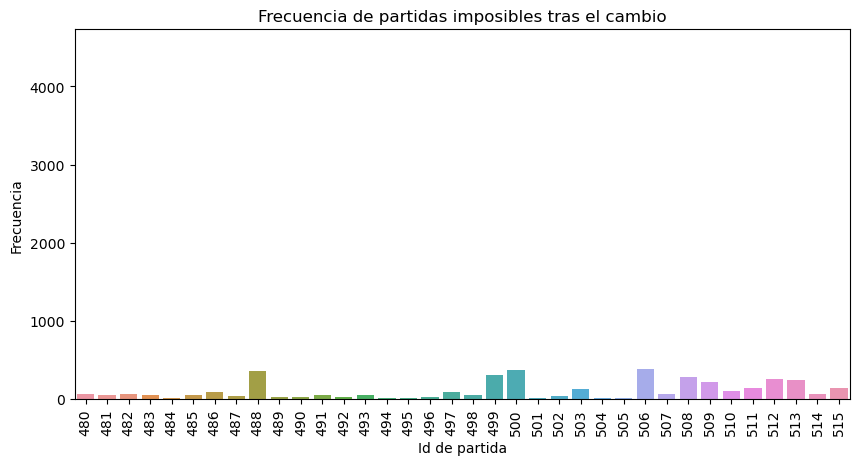

In [80]:
small_w = wrong.loc[wrong['Game'] > 479]
word_plot2 = sns.countplot(data = small_w, x = 'Game')
word_plot2.set_xlabel("Id de partida")
word_plot2.set_ylabel("Frecuencia")
word_plot2.set_title("Frecuencia de partidas imposibles tras el cambio")
word_plot2.set_xticklabels(labels = word_plot.get_xticklabels() ,rotation = 90);
word_plot2.set_ylim(word_plot.get_ylim()[0], word_plot.get_ylim()[1])
word_plot2.figure.set_figwidth(10);

In [81]:
fig = word_plot2.get_figure()
fig.savefig('impossible_games2.png')

## Saving the results

In [82]:
data = data.loc[data['valid_game'] == True]

In [83]:
data = data.drop(['valid_game'], axis = 1)

In [86]:
data

level_0  index  Game  Trial         Username  \
0              0      0   196      1     adamhorsfall   
1              1      1   196      1     TheRealPembo   
2              2      2   196      1           grenow   
3              3      3   196      1         Yummhh__   
4              4      4   196      1  TowerGuardGames   
...          ...    ...   ...    ...              ...   
6923123  6954101  19156   515      7     moona_moony_   
6923124  6954102  19157   515      7       JonMDexter   
6923125  6954103  19158   515      7       KuronaNuva   
6923126  6954104  19159   515      7           KZYONE   
6923127  6954105  19160   515      7       Robtrinity   

                                     processed_text target  
0                                           [üü©üü©üü©üü©üü©]  REBUS  
1                                           [üü©üü©üü©üü©üü©]  REBUS  
2                                           [üü©üü©üü©üü©üü©]  REBUS  
3                                           [üü©üü©üü©üü©üü©]  REBUS  
4                                           [üü©üü©üü©üü©üü©]  REBUS  
...                                             ...    ...  
6923123  [üü®‚¨ú‚¨ú‚¨úüü®, ‚¨úüü®üü®‚¨ú‚¨ú, ‚¨ú‚¨úüü®üü®üü©, ‚¨úüü©‚¨úüü©üü©, ‚¨úüü©‚¨úüü©üü©, ‚¨úüü©‚¨úüü©üü©]  BAKER  
6923124  [‚¨ú‚¨ú‚¨ú‚¨úüü©, ‚¨ú‚¨ú‚¨úüü©üü©, ‚¨úüü©‚¨úüü©üü©, ‚¨úüü©‚¨úüü©üü©, ‚¨úüü©üü©üü©üü©, ‚¨úüü©üü©üü©üü©]  BAKER  
6923125  [‚¨úüü®üü®‚¨úüü®, üü®üü©üü®‚¨ú‚¨ú, ‚¨úüü©‚¨úüü©üü©, ‚¨úüü©‚¨úüü©üü©, ‚¨úüü©‚¨úüü©üü©, ‚¨úüü©‚¨úüü©üü©]  BAKER  
6923126  [üü®üü®üü®‚¨ú‚¨ú, ‚¨úüü®üü®üü®‚¨ú, ‚¨ú‚¨úüü®üü®üü®, ‚¨úüü©‚¨úüü©üü©, ‚¨úüü©‚¨úüü©üü©, ‚¨úüü©‚¨úüü©üü©]  BAKER  
6923127  [‚¨ú‚¨úüü®‚¨ú‚¨ú, ‚¨úüü®üü®‚¨úüü®, üü®üü©‚¨úüü©‚¨ú, ‚¨úüü©‚¨úüü©üü©, ‚¨úüü©‚¨úüü©üü©, ‚¨úüü©‚¨úüü©üü©]  BAKER  

[6923128 rows x 7 columns]

In [85]:
data = data.reset_index()
data.to_feather('data_proc_ver_2.feather')